In [1]:
!pip install "numpy<2.0"
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Dataset

In [2]:
!pip install kagglehub

In [1]:
import kagglehub
coco2014_path = kagglehub.dataset_download('yhhhrerr/coco2014')

In [2]:
coco2014_path

'/root/.cache/kagglehub/datasets/yhhhrerr/coco2014/versions/2'

In [3]:
!wget http://www.cs.toronto.edu/~mren/imageqa/data/cocoqa/cocoqa-2015-05-17.zip

--2025-05-22 15:27:02--  http://www.cs.toronto.edu/~mren/imageqa/data/cocoqa/cocoqa-2015-05-17.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1859880 (1.8M) [application/zip]
Saving to: ‘cocoqa-2015-05-17.zip.1’

cocoqa-2015-05-17.z 100%[===================>]   1.77M  1.19MB/s    in 1.5s    

2025-05-22 15:27:04 (1.19 MB/s) - ‘cocoqa-2015-05-17.zip.1’ saved [1859880/1859880]



In [4]:
!unzip cocoqa-2015-05-17.zip

Archive:  cocoqa-2015-05-17.zip
replace test/answers.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Download and Import Requirements

In [5]:
import torch
import torch.nn as nn
import torchtext
import os
import random
import numpy as np
import pandas as pd
import spacy
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision import transforms

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

## Read Dataset

In [7]:
import os

def read_dataset(questions_path, answers_path, img_ids_path, types_path):
    with open(questions_path, 'r') as f_q, \
         open(answers_path, 'r') as f_a, \
         open(img_ids_path, 'r') as f_img, \
         open(types_path, 'r') as f_t:

        questions = [q.strip() for q in f_q.readlines()]
        answers = [a.strip() for a in f_a.readlines()]
        img_ids = [int(img_id.strip()) for img_id in f_img.readlines()]
        types = [t.strip() for t in f_t.readlines()]

    if not (len(questions) == len(answers) == len(img_ids) == len(types)):
        raise ValueError("Các file đầu vào có số lượng dòng không khớp")

    data = []
    for q, a, img_id, t in zip(questions, answers, img_ids, types):
        padded_id = f"{img_id:012d}"
        train_part = "train2014"
        val_part = "val2014"
        train_img_path = f"{coco2014_path}/COCO2014/images/{train_part}/COCO_{train_part}_{padded_id}.jpg"
        val_img_path = f"{coco2014_path}/COCO2014/images/{val_part}/COCO_{val_part}_{padded_id}.jpg"
        if os.path.exists(train_img_path):
            img_filename = train_img_path
        elif os.path.exists(val_img_path):
            img_filename = val_img_path
        else:
            print("No Exist")

        data.append({
            'question': q,
            'answer': a,
            'type': int(t),
            'img_path': img_filename
        })

    return data

In [8]:
train_questions_path = "/content/train/questions.txt"
train_answers_path = "/content/train/answers.txt"
train_img_ids_path = "/content/train/img_ids.txt"
train_types_path = "/content/train/types.txt"

train_data = read_dataset(train_questions_path, train_answers_path, train_img_ids_path, train_types_path)

In [9]:
val_questions_path = "/content/test/questions.txt"
val_answers_path = "/content/test/answers.txt"
val_img_ids_path = "/content/test/img_ids.txt"
val_types_path = "/content/test/types.txt"

val_data = read_dataset(val_questions_path, val_answers_path, val_img_ids_path, val_types_path)

## Build Tokenizers

In [10]:
eng = spacy.load("en_core_web_sm")

def get_tokens(data_iter):
    for sample in data_iter:
        question = sample["question"]
        yield [token.text for token in eng.tokenizer(question)]

vocab = build_vocab_from_iterator(
    get_tokens(train_data),
    specials=["<pad>", "<unk>", "<sos>", "<eos>"],
    special_first=True
)

vocab.set_default_index(vocab["<unk>"])

In [11]:
len(vocab)

9944

In [12]:
def tokenize(question, max_seq_len):
    tokens = [token.text for token in eng.tokenizer(question)]
    sequence = [vocab[token] for token in tokens]
    if len(sequence) < max_seq_len:
        sequence += [vocab['<pad>']] * (max_seq_len - len(sequence))
    else:
        sequence = sequence[:max_seq_len]

    return sequence

In [13]:
example_question = "Is this a picture of an apple?"
max_seq_len = 20

tokenize(example_question, max_seq_len)

[1, 157, 7, 220, 8, 25, 517, 6176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:

classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}

## Pytorch Dataset

In [15]:
class VQADataset(Dataset):
    def __init__(self, data, label2idx, max_seq_len=20, transform=None, img_dir="/kaggle/input/coco2014/COCO2014/images"):
        self.data = data
        self.max_seq_len = max_seq_len
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]["img_path"]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        question = self.data[index]["question"]
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        type_ = torch.tensor(self.data[index]["type"])
        label = self.data[index]["answer"]
        label = self.label2idx[label]
        label = torch.tensor(label, dtype=torch.long)

        return img, question, type_, label

In [16]:
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.CenterCrop(size=180),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

In [17]:
train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    transform=data_transform['train']
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    transform=data_transform['val']
)

In [19]:
train_batch_size = 128
test_batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## Build Model

In [20]:
class VQAModel(nn.Module):
    def __init__(
        self,
        n_classes,
        img_model_name,
        embedding_dim,
        n_layers=2,
        hidden_size=256,
        drop_p=0.2
    ):
        super(VQAModel, self).__init__()
        self.img_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )
        for param in self.img_encoder.parameters():
            param.requires_grad = True

        self.question_encoder = nn.Sequential(
            nn.Embedding(len(vocab), embedding_dim),
            nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_size,
                num_layers=n_layers,
                batch_first=True,
                bidirectional=True,
                dropout=drop_p
            )
        )

        self.type_encoder = nn.Embedding(4, 32)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*3 + 32, hidden_size),
            nn.Dropout(drop_p),
            nn.GELU(),
            nn.Linear(hidden_size, n_classes)
        )

    def forward(self, img, question, type_):
        img_features = self.img_encoder(img)

        lstm_out, _ = self.question_encoder(question)
        lstm_out = lstm_out[:, -1, :]

        type_feature = self.type_encoder(type_)

        combined = torch.cat([img_features, lstm_out, type_feature], dim=1)
        x = self.classifier(combined)

        return x

In [21]:
n_classes = len(classes)
img_model_name = "resnet18"
hidden_size = 256
n_layers = 2
embedding_dim = 128
drop_p = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [22]:
images, questions, types, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    types = types.to(device)
    output = model(images, questions, types)
    print(output.shape)

torch.Size([128, 430])


## Training

In [23]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, type_, labels in dataloader:
            image, question, type_, labels = image.to(device), question.to(device), type_.to(device), labels.to(device)
            outputs = model(image, question, type_)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [24]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, types_, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            types_ = types_.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions, types_)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [25]:
lr = 1e-3
epochs = 10

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [26]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 3.4244	Val loss: 3.0053	Val Acc: 0.2792697956249358
EPOCH 2:	Train loss: 2.6669	Val loss: 2.5665	Val Acc: 0.3778884666735134
EPOCH 3:	Train loss: 2.2568	Val loss: 2.5810	Val Acc: 0.3739601519975352
EPOCH 4:	Train loss: 1.9822	Val loss: 2.2798	Val Acc: 0.42975249050015407
EPOCH 5:	Train loss: 1.7506	Val loss: 2.1918	Val Acc: 0.4590222861250899
EPOCH 6:	Train loss: 1.5531	Val loss: 2.2155	Val Acc: 0.456249358118517
EPOCH 7:	Train loss: 1.1138	Val loss: 2.0678	Val Acc: 0.5059566601622676
EPOCH 8:	Train loss: 0.9630	Val loss: 2.1141	Val Acc: 0.5020540207456096
EPOCH 9:	Train loss: 0.8713	Val loss: 2.1664	Val Acc: 0.4990756906644757
EPOCH 10:	Train loss: 0.7982	Val loss: 2.2303	Val Acc: 0.49478792235801583


In [27]:
torch.save(model.state_dict(), 'vqa_model.pth')
print("Model saved to vqa_model.pth")

Model saved to vqa_model.pth


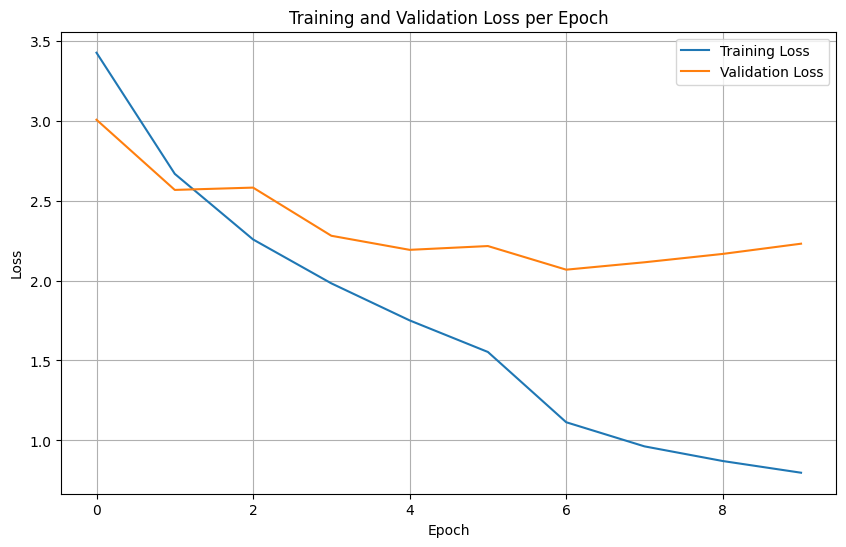

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# prompt: load model

model = VQAModel(
    n_classes=n_classes,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    drop_p=drop_p
).to(device)
model.load_state_dict(torch.load('vqa_model.pth'))
model.eval()

VQAModel(
  (img_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# prompt: evaluate with val_dataset

test_loss, test_acc = evaluate(model, val_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')